In [1]:
using Pkg
Pkg.activate("..")

 Activating environment at `~/Documents/Catlab/AlgebraicDynamics.jl/Project.toml`


In [79]:
using AlgebraicDynamics

using Catlab
using Catlab.CategoricalAlgebra
using Catlab.CategoricalAlgebra.CSets
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Catlab.Graphs

using Plots

# Implementing Resources Sharing Machines

In this notebook, we describe the process of composing dynamical systems as (1) resource sharers, (2) machines, and (3) resource sharing machines.

These features are implemented more complicated-ly in the AlgebraicDynamics.jl package. In this notebook we implement "baby" versions for the sake of clarity.

## A Theory of Machines

We define a machine to be a system which takes input, updates its internal state, and exposes some output. The schema for machines is:

<img src="images/Theory of Machines.png" alt="schema for theory of machines" style="width: 600px;"/>

Note that this composition pattern is a special case of an operation in the operad of wiring diagrams of finite sets where the codomain is the unit.

In [3]:
@present TheoryMachines(FreeSchema) begin        
    Value::Data
    Dynamics::Data

    Box::Ob
    InPort::Ob
    OutPort::Ob
    StateVariable::Ob

    parameterizes::Hom(InPort, Box)
    state::Hom(OutPort, StateVariable)
    system::Hom(StateVariable, Box)
    feeder::Hom(InPort, OutPort)
    
    value::Attr(StateVariable, Value)
    dynamics::Attr(Box, Dynamics)
end

const AbstractMachine = AbstractACSetType(TheoryMachines)
const Machine = ACSetType(TheoryMachines, index=[:parameterizes, :state, :system, :value, :feeder, :dynamics])
Machine() = Machine{Real, Function}()

Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:Box, :InPort, :OutPort, :StateVariable),(:parameterizes, :state, :system, :feeder),(2, 3, 4, 2),(1, 4, 1, 3)},Catlab.Theories.AttrDesc{Catlab.Theories.CatDesc{(:Box, :InPort, :OutPort, :StateVariable),(:parameterizes, :state, :system, :feeder),(2, 3, 4, 2),(1, 4, 1, 3)},(:Value, :Dynamics),(:value, :dynamics),(4, 1),(1, 2)},Tuple{Value,Dynamics},(:dynamics, :feeder, :parameterizes, :state, :system, :value),(),Tables,Indices} where Indices<:NamedTuple where Tables<:NamedTuple where Dynamics where Value

## Lokta-Volterra as machines

A parameterized ODE modeling a rabbit population takes as input a population of predators $i$ and evolves according to $$\dot r = \alpha r - \beta i r$$.

Similarly a ODE modeling a fox population takes as input a population of prey $j$ and evolves according to $$\dot f = -\gamma f + \delta j f$$

We can discretize these continuous dynamical systems via Euler's method: 
$$r_n(i) = r_{n -1} + h\dot r(r_{n - 1}, i), \quad f_n(j) = f_{n-1} + h \dot f(f_{n -1 }, j)$$

And now exposing the rabbit and fox populations 

In [103]:
α = 1.2
β = 0.1
γ = 1.3
δ = 0.1

dotr = (r,i) -> [α*r[1] - β*i[1]*r[1]]
dotf = (f,j) -> [-γ*f[1] + δ* j[1]* f[1]]

function eulers(f::Function, h::Float64) 
    return (x, args...) -> x + h*f(x, args...)
end

h = 0.01

lv = Machine()
add_parts!(lv, :Box,    2, dynamics = [eulers(dotr, h), eulers(dotf, h)])
add_parts!(lv, :StateVariable,  2, system = [1,2], value=[10, 10])
add_parts!(lv, :OutPort,2, state = [1,2])
add_parts!(lv, :InPort, 2, parameterizes = [1,2], feeder = [2,1])

lv

ACSet with elements Box = 1:2, InPort = 1:2, OutPort = 1:2, StateVariable = 1:2
┌─────┬──────────┐
│ Box │ dynamics │
├─────┼──────────┤
│   1 │     #167 │
│   2 │     #167 │
└─────┴──────────┘
┌────────┬───────────────┬────────┐
│ InPort │ parameterizes │ feeder │
├────────┼───────────────┼────────┤
│      1 │             1 │      2 │
│      2 │             2 │      1 │
└────────┴───────────────┴────────┘
┌─────────┬───────┐
│ OutPort │ state │
├─────────┼───────┤
│       1 │     1 │
│       2 │     2 │
└─────────┴───────┘
┌───────────────┬────────┬───────┐
│ StateVariable │ system │ value │
├───────────────┼────────┼───────┤
│             1 │      1 │    10 │
│             2 │      2 │    10 │
└───────────────┴────────┴───────┘

Next we create an update function that modularly updates each box of the system. And we can run it to view the evolution of rabbit and fox populations over time. 

In [104]:
function update!(y::AbstractVector, f::Function, x::AbstractVector, args...)
    @show x
    y .= f(x, args...)
end

function update!(newstate::AbstractVector, dm::AbstractMachine, state::AbstractVector) 
    
    for b in parts(dm, :Box)
        ivalues = view(state,  subpart(dm, incident(dm, b, :parameterizes), :feeder))
        states = incident(dm, b, :system)
        dynamics = subpart(dm, b, :dynamics)
        newvalues = update!(view(newstate, states),
                            dynamics, 
                            view(state, states), 
                            ivalues)
    end
    
    return newstate
end

update! (generic function with 4 methods)

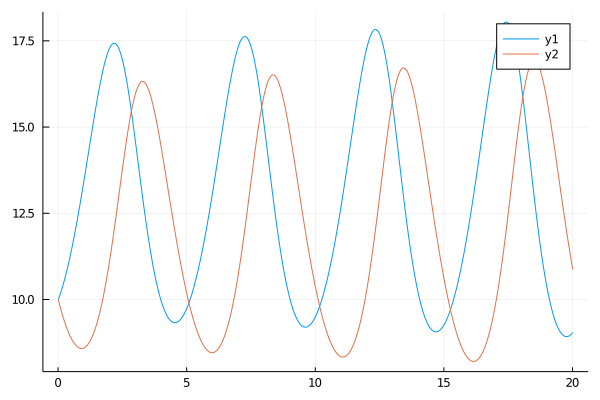

In [110]:
N = 2000
k = nparts(lv, :StateVariable)

xs = Array{Float64}(undef, N + 1, k)
xs[1, : ] = subpart(lv, :value)

for i in 1:N
    update!(view(xs,i+1, 1:k), lv, view(xs, i, 1:k))
end

ts = map(t -> t*h, 1:N+1)
rs = xs[:, 1]
fs = xs[:, 2]

plot(ts, rs)
plot!(ts, fs)

Part of the beauty of this compositional approach is the modularity of the system. For example, suppose we had a second population of rabbit predators --- hawks --- modeled by the paramterized ODE
$$\dot h = 

In [58]:
update!([0, 1], (z, y) -> z + y, [10, 1], [1,1])

2-element Array{Int64,1}:
 11
  2

0.0:2.0:0.0

In [76]:
xs[:, 2]

101-element Array{Float64,1}:
 10.0
  9.7
  9.4284
  9.1865238264
  8.975503510680149
  8.796357911674376
  8.650063762407829
  8.537619089193656
  8.460098881339396
  8.418702580649828
  8.41479240643325
  8.449920715048266
  8.52584348619895
  ⋮
 18.80466183951222
 17.945728507461403
 17.023057170111684
 16.068284689169612
 15.107405964693145
 14.160841544790696
 13.243950881241094
 12.367753567184483
 11.539702013256951
 10.76441495940577
 10.044327455916823
  9.380242036978135